# Index Differences Between Fields
This notebook looks at how papers have different pageranks between fields

In [1]:
import glob
import itertools
import pickle as pkl
import sys
from functools import lru_cache

import numpy as np
import pandas as pd
import plotly.express as px
from plotnine import *
from tqdm import tqdm

sys.path.append('../indices')
from utils import parse_metadata

In [5]:
def calculate_percentiles(true_vals, doi_to_shuffled_metrics):
    dois, pageranks = [], []
    for doi, pagerank in true_vals.items():
        if pagerank is not None:
            dois.append(doi)
            pageranks.append(pagerank)
            
    percentiles = []
    for doi in dois:
        if doi not in doi_to_shuffled_metrics:
            percentiles.append(None)
            continue
        
        shuffled_metrics = doi_to_shuffled_metrics[doi]
        # If the node is unshuffleable for some reason, its percentile isn't meaningful
        if len(set(shuffled_metrics)) == 1:
            percentiles.append(None)
            continue
        true_val = true_vals[doi]
    
        percentile = np.searchsorted(shuffled_metrics, true_val) / 100
        percentiles.append(percentile)

    result_df = pd.DataFrame({'doi': dois, 'pagerank': pageranks, 'percentile': percentiles})
    return result_df

In [6]:
@lru_cache(2)
def load_single_heading(heading_str):
    heading_shuffled = glob.glob(f'../output/shuffle_results/{heading_str}*-pagerank.pkl')

    doi_to_shuffled_metrics = {}

    for path in heading_shuffled:
        with open(path, 'rb') as in_file:
            result = pkl.load(in_file)
            for doi, value in result.items():
                if doi in doi_to_shuffled_metrics:
                    doi_to_shuffled_metrics[doi].append(value)
                else:
                    doi_to_shuffled_metrics[doi] = [value]
    for doi, vals in doi_to_shuffled_metrics.items():
        doi_to_shuffled_metrics[doi] = sorted(vals)
    
    with open(f'../output/{heading_str}-pagerank.pkl', 'rb') as in_file:
        true_vals = pkl.load(in_file)
        
    heading_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
    return heading_df

def load_pair_headings(heading1, heading2):
    heading1_df = load_single_heading(f'{heading1}-{heading2}')
    heading2_df = load_single_heading(f'{heading2}-{heading1}')

    merged_df = heading1_df.merge(heading2_df, on='doi')
    merged_df = merged_df.rename({'pagerank_x': f'{heading1}_pagerank', 'pagerank_y': f'{heading2}_pagerank',
                                  'percentile_x': f'{heading1}_percentile', 'percentile_y': f'{heading2}_percentile'}, 
                                 axis='columns')
    merged_df[f'{heading1}-{heading2}'] = merged_df[f'{heading1}_percentile'] - merged_df[f'{heading2}_percentile']
    
    metadata_df = parse_metadata(f'../data/pubmed/efetch/{heading1}.xml.xz')
    full_df = merged_df.merge(metadata_df, on='doi')
    
    return full_df

## Load AI results

In [ ]:
ai_shuffled = glob.glob('../output/shuffle_results/artificial_intelligence_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in ai_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [ ]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [ ]:
with open('../output/artificial_intelligence-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)

In [ ]:
ai_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
ai_df

In [ ]:
ai_df['percentile'].hist()

In [ ]:
ai_df['percentile'].value_counts() / len(ai_df)

## Load comp bio resuls

In [ ]:
comp_bio_shuffled = glob.glob('../output/shuffle_results/computational_biology_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in comp_bio_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [ ]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [ ]:
with open('../output/computational_biology-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)
    
comp_bio_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
comp_bio_df


In [ ]:
comp_bio_df['percentile'].hist()

## Load Genetics results

In [ ]:
genetics_shuffled = glob.glob('../output/shuffle_results/genetics_*-pagerank.pkl')

doi_to_shuffled_metrics = {}

for path in genetics_shuffled:
    with open(path, 'rb') as in_file:
        result = pkl.load(in_file)
        for doi, value in result.items():
            if doi in doi_to_shuffled_metrics:
                doi_to_shuffled_metrics[doi].append(value)
            else:
                doi_to_shuffled_metrics[doi] = [value]
                

In [ ]:
for doi, vals in doi_to_shuffled_metrics.items():
    doi_to_shuffled_metrics[doi] = sorted(vals)

In [ ]:
with open('../output/genetics-pagerank.pkl', 'rb') as in_file:
    true_vals = pkl.load(in_file)
    
genetics_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
genetics_df


In [ ]:
genetics_df['percentile'].hist()

## Merge ai and comp bio and plot results

In [ ]:
merged_df = comp_bio_df.merge(ai_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'comp_bio_pagerank', 'pagerank_y': 'ai_pagerank',
                              'percentile_x': 'comp_bio_percentile', 'percentile_y': 'ai_percentile'}, 
                             axis='columns')
merged_df['cb-ai'] = merged_df['comp_bio_percentile'] - merged_df['ai_percentile']

merged_df

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='comp_bio_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='ai_percentile', title='ai percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='cb-ai', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and ai')
fig.show()

In [ ]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in ai
merged_df.sort_values(by='cb-ai', ascending=False).head(5)

In [ ]:
merged_df.sort_values(by='cb-ai', ascending=True).head(5)

Papers that did very well in CB and very poorly in ai include:
- "Symtosis: A liver ultrasound tissue characterization and risk stratification in optimized deep learning paradigm"
- "Automated detection of COVID-19 cases using deep neural networks with X-ray images"
- "COVID-19 detection using deep learning models to exploit Social Mimic Optimization and structured chest X-ray images using fuzzy color and stacking approache"
- "Application of deep learning technique to manage COVID-19 in routine clinical practice using CT images: Results of 10 convolutional neural networks"
- "PCA-based polling strategy in machine learning framework for coronary artery disease risk assessment in intravascular ultrasound: A link between carotid and coronary grayscale plaque morphology"

Papers that did well in AI but poorly in CB:
- "Activities at the Universal Protein Resource (UniProt)"
- "Lipidomic data analysis: Tutorial, practical guidelines and applications"
- "A Novel Method for the Simultaneous Enrichment, Identification, and Quantification of Phosphopeptides and Sialylated Glycopeptides Applied to a Temporal Profile of Mouse Brain Development*"
- "Peptide Fingerprinting of Alzheimer's Disease in Cerebrospinal Fluid: Identification and Prospective Evaluation of New Synaptic Biomarkers"
- "CliqueMS: a computational tool for annotating in-source metabolite ions from LC-MS untargeted metabolomics data based on a coelution similarity network "


## Merge genetics and comp bio and plot results

In [ ]:
merged_df = comp_bio_df.merge(genetics_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'comp_bio_pagerank', 'pagerank_y': 'genetics_pagerank',
                              'percentile_x': 'comp_bio_percentile', 'percentile_y': 'genetics_percentile'}, 
                             axis='columns')
merged_df['cb-genetics'] = merged_df['comp_bio_percentile'] - merged_df['genetics_percentile']

merged_df

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='comp_bio_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='genetics_percentile', title='Genetics percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='comp_bio_pagerank', y='genetics_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='cb-genetics', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and genetics')
fig.show()

In [ ]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in genetics
merged_df.sort_values(by='cb-genetics', ascending=False).head(5)

In [ ]:
merged_df.sort_values(by='cb-genetics', ascending=True).head(5)

Papers that did very well in CB and very poorly in genetics include:
- "Analysis of genomic diversity in Mexican Mestizo populations to develop genomic medicine in Mexico" 
- "Deciphering next-generation pharmacogenomics: an information technology perspective
- "A Serum Proteomic Pattern for the Detection of Colorectal Adenocarcinoma Using Surface Enhanced Laser Desorption and Ionization Mass Spectrometry
- "Mechanisms of population differentiation in seabirds"
- "Quantitative phenotyping via deep barcode sequencing

Papers that did well in genetics but not in CB:
- "Deep learning extends de novo protein modelling coverage of genomes using iteratively predicted structural constraints"
- "O-GlcNAcPRED-II: an integrated classification algorithm for identifying O-GlcNAcylation sites based on fuzzy undersampling and a K-means PCA oversampling technique"
- "DRIMM-Synteny: decomposing genomes into evolutionary conserved segments"
- "PseKRAAC: a flexible web server for generating pseudo K-tuple reduced amino acids composition"
- "GPSuc: Global Prediction of Generic and Species-specific Succinylation Sites by aggregating multiple sequence features"

## Merge ai and genetics and plot results

In [ ]:
merged_df = genetics_df.merge(ai_df, on='doi')
merged_df = merged_df.rename({'pagerank_x': 'genetics_pagerank', 'pagerank_y': 'ai_pagerank',
                              'percentile_x': 'genetics_percentile', 'percentile_y': 'ai_percentile'}, 
                             axis='columns')
merged_df['genetics-ai'] = merged_df['genetics_percentile'] - merged_df['ai_percentile']

merged_df

In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='genetics_percentile', title='Comp bio percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.3, color='ai_percentile', title='ai percentiles')
fig.show()

In [ ]:
fig = px.scatter(merged_df, x='genetics_pagerank', y='ai_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='genetics-ai', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in genetics and ai')
fig.show()

In [ ]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in ai
merged_df.sort_values(by='genetics-ai', ascending=False).head(5)

In [ ]:
merged_df.sort_values(by='genetics-ai', ascending=True).head(5)

Papers that did very well in Genetics and very poorly in ai include:
- "Active learning for computational chemogenomics"
- "O-GlcNAcPRED-II: an integrated classification algorithm for identifying O-GlcNAcylation sites based on fuzzy undersampling and a K-means PCA oversampling technique"
- "Identifying RNA 5-methylcytosine sites via pseudo nucleotide compositions"
- "AOD: the antioxidant protein database"
- "University of Turku in the BioNLP'11 Shared Task"

Papers that did well in AI but poorly in genetics:
- "The genomics of selection in dogs and the parallel evolution between dogs and humans"
- "Population genomic evidence for adaptive differentiation in Baltic Sea three-spined sticklebacks"
- "A Novel Method for the Simultaneous Enrichment, Identification, and Quantification of Phosphopeptides and Sialylated Glycopeptides Applied to a Temporal Profile of Mouse Brain Development*"
- "Use of resistance surfaces for landscape genetic studies: considerations for parameterization and analysis
- "Adaptations to Climate-Mediated Selective Pressures in Sheep "


## Merged results
### Comp bio vs Genetics

In [7]:
merged_df = load_pair_headings('computational_biology', 'genetics')

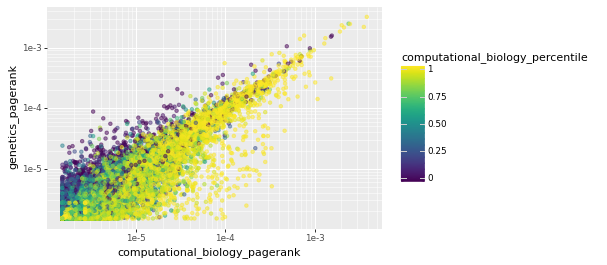

<ggplot: (8759344588653)>

In [8]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='computational_biology_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

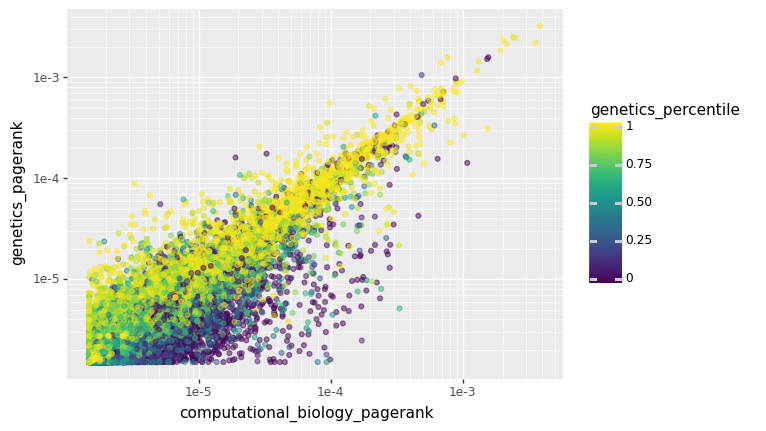

<ggplot: (8759298573550)>

In [9]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='genetics_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

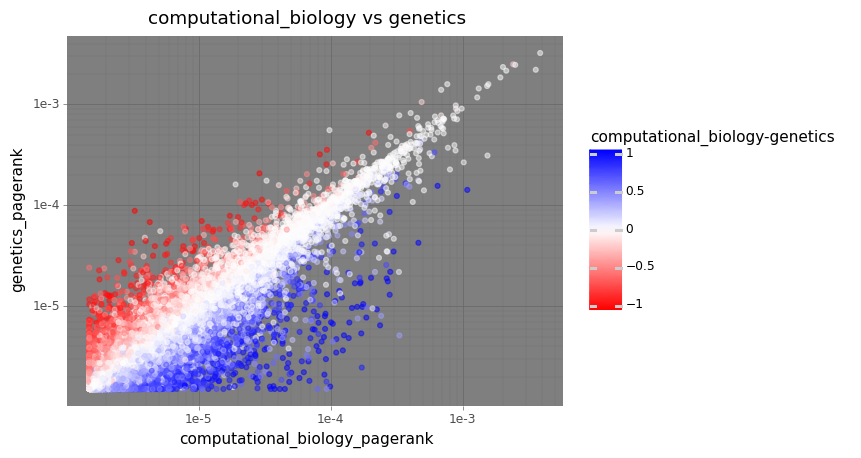

<ggplot: (8759319457390)>

In [10]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank', color='computational_biology-genetics'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs genetics')
plot

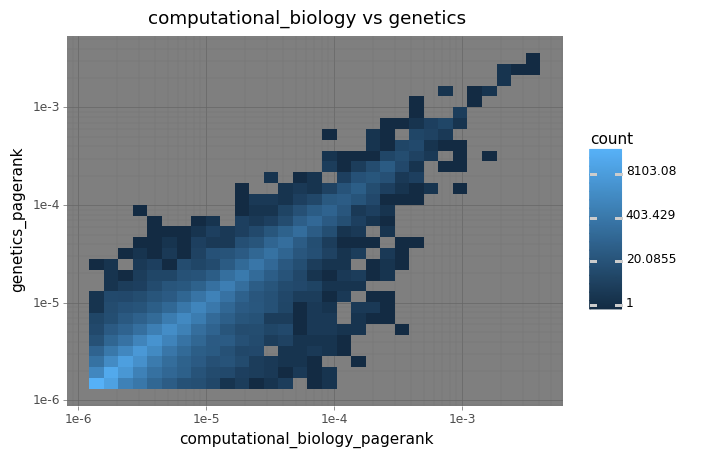

<ggplot: (8759298964450)>

In [11]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='genetics_pagerank',))

plot += geom_bin2d()
plot += scale_y_log10()
plot += scale_x_log10()
plot += theme_dark()
plot += scale_fill_gradient(trans='log')
plot += ggtitle('computational_biology vs genetics')
plot

In [12]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in genetics
merged_df.sort_values(by='computational_biology-genetics', ascending=False).head(5)

doi  computational_biology_pagerank  \
800            10.1038/nrd1776                        0.000282   
1066         10.1021/ac0519312                        0.000186   
917          10.1021/tx700335d                        0.000170   
916   10.1177/0192623307310947                        0.000058   
76     10.1126/science.1069492                        0.000644   

      computational_biology_percentile  genetics_pagerank  \
800                                1.0           0.000022   
1066                               1.0           0.000008   
917                                1.0           0.000005   
916                                1.0           0.000002   
76                                 1.0           0.000156   

      genetics_percentile  computational_biology-genetics      pmid pmcid  \
800                   0.0                             1.0  16052242  None   
1066                  0.0                             1.0  16579606  None   
917                   0.0                             1.0  18171018  None   
916                   0.0                             1.0  18337232  None   
76                    0.0                             1.0  11872829  None   

                  journal journal_nlm_id  \
800   Nat Rev Drug Discov      101124171   
1066            Anal Chem        0370536   
917      Chem Res Toxicol        8807448   
916        Toxicol Pathol        7905907   
76                Science        0404511   

                                                  title publication_date  \
800                   The emerging field of lipidomics.          2005-07   
1066  Scaling and normalization effects in NMR spect...       2006-04-01   
917   NMR-based metabolic profiling and metabonomic ...       2008-01-03   
916   Metabolic profiling as a tool for understandin...          2008-01   
76                   Systems biology: a brief overview.       2002-03-01   

                                                authors  
800   [{'fore_name': 'Markus R', 'last_name': 'Wenk'...  
1066  [{'fore_name': 'Andrew', 'last_name': 'Craig',...  
917   [{'fore_name': 'Muireann', 'last_name': 'Coen'...  
916   [{'fore_name': 'Christopher J', 'last_name': '...  
76    [{'fore_name': 'Hiroaki', 'last_name': 'Kitano...

In [13]:
merged_df.sort_values(by='computational_biology-genetics', ascending=True).head(5)

doi  computational_biology_pagerank  \
20216       10.1073/pnas.0711303105                        0.000004   
12690             10.1159/000472383                        0.000003   
3974            10.1038/nature06810                        0.000029   
707    10.1371/journal.pcbi.1000520                        0.000083   
21757  10.1371/journal.pcbi.1001061                        0.000003   

       computational_biology_percentile  genetics_pagerank  \
20216                               0.0           0.000068   
12690                               0.0           0.000088   
3974                                0.0           0.000207   
707                                 0.0           0.000320   
21757                               0.0           0.000042   

       genetics_percentile  computational_biology-genetics      pmid  \
20216                 1.00                           -1.00  18467493   
12690                 1.00                           -1.00   7520820   
3974                  1.00                           -1.00  18337718   
707                   0.99                           -0.99  19779555   
21757                 0.99                           -0.99  21283775   

            pmcid                   journal journal_nlm_id  \
20216  PMC2383945  Proc Natl Acad Sci U S A        7505876   
12690        None           Eur J Hum Genet        9302235   
3974         None                    Nature        0410462   
707    PMC2740835          PLoS Comput Biol      101238922   
21757  PMC3024254          PLoS Comput Biol      101238922   

                                                   title publication_date  \
20216  Diverse syntrophic partnerships from deep-sea ...       2008-05-08   
12690  Human genomic diversity in Europe: a summary o...             1993   
3974    Functional metagenomic profiling of nine biomes.       2008-03-12   
707             Bayesian phylogeography finds its roots.       2009-09-25   
21757  PhylOTU: a high-throughput procedure quantifie...       2011-01-20   

                                                 authors  
20216  [{'fore_name': 'Annelie', 'last_name': 'Pernth...  
12690  [{'fore_name': 'L L', 'last_name': 'Cavalli-Sf...  
3974   [{'fore_name': 'Elizabeth A', 'last_name': 'Di...  
707    [{'fore_name': 'Philippe', 'last_name': 'Lemey...  
21757  [{'fore_name': 'Thomas J', 'last_name': 'Sharp...

### High CB-genetics:
- Nonlinear Data Alignment for UPLC−MS and HPLC−MS Based Metabolomics:  Quantitative Analysis of Endogenous and Exogenous Metabolites in Human Serum
- Plant metabolomics: from holistic hope, to hype, to hot topic
- Engineered gene circuits
- Genetics Meets Metabolomics: A Genome-Wide Association Study of Metabolite Profiles in Human Serum
- Metabonomics Techniques and Applications to Pharmaceutical Research & Development

### Low CB - genetics:
- PhylOTU: A High-Throughput Procedure Quantifies Microbial Community Diversity and Resolves Novel Taxa from Metagenomic Data
- Functional metagenomic profiling of nine biomes
- A human gut microbial gene catalogue established by metagenomic sequencing
- Phymm and PhymmBL: metagenomic phylogenetic classification with interpolated Markov models
- The Plant Ontology as a Tool for Comparative Plant Anatomy and Genomic Analyses 

### Comp bio vs AI

In [14]:
merged_df = load_pair_headings('computational_biology', 'artificial_intelligence')

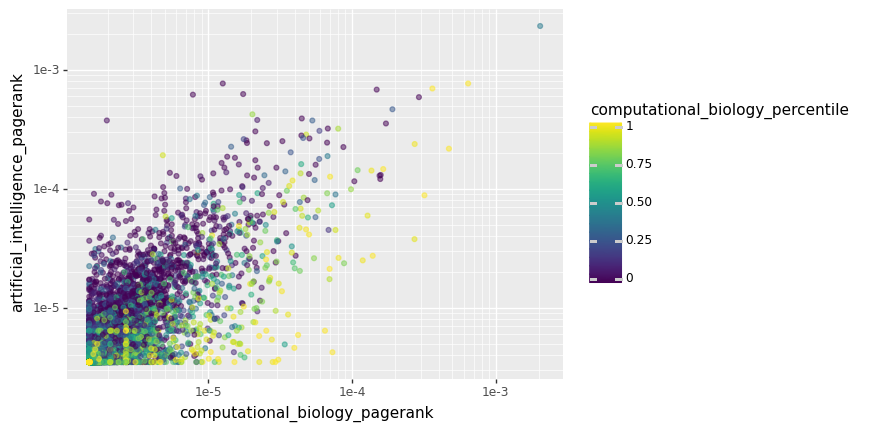

<ggplot: (8759300967464)>

In [15]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='computational_biology_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

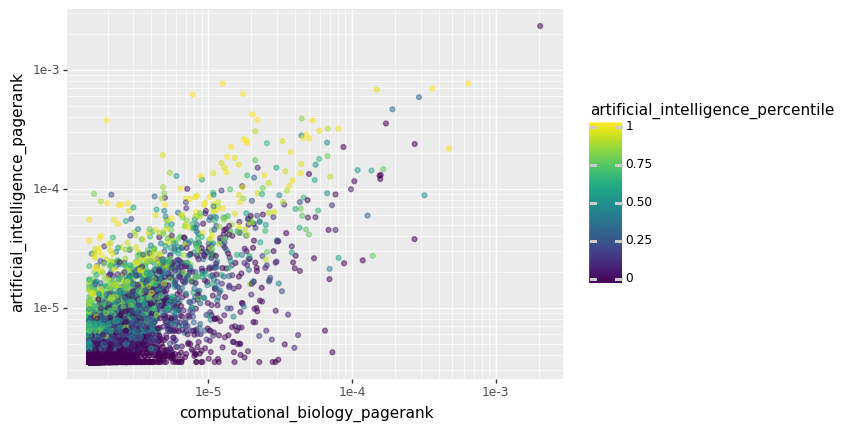

<ggplot: (8759321635621)>

In [16]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='artificial_intelligence_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

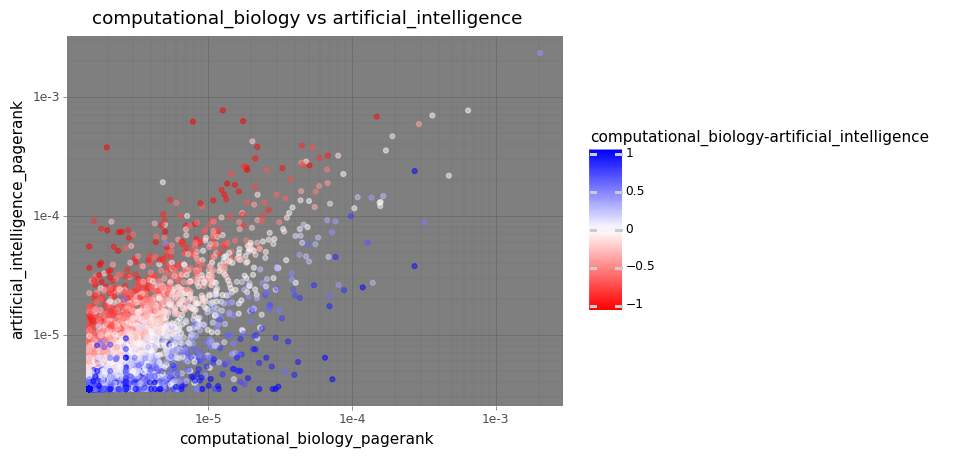

<ggplot: (8759298574622)>

In [17]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='artificial_intelligence_pagerank', color='computational_biology-artificial_intelligence'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs artificial_intelligence')
plot

In [18]:
# Get papers that did surprisingly well in comp bio but surprisingly poorly in artificial_intelligence
merged_df.sort_values(by='computational_biology-artificial_intelligence', ascending=False).head(5)

doi  computational_biology_pagerank  \
8815    10.1182/blood.2021013054                        0.000001   
5793  10.1038/s41592-021-01205-4                        0.000001   
7529       10.3892/mmr.2019.9984                        0.000001   
7528       10.3892/mmr.2019.9961                        0.000001   
3613         10.1098/rsob.160132                        0.000001   

      computational_biology_percentile  artificial_intelligence_pagerank  \
8815                               1.0                          0.000004   
5793                               1.0                          0.000004   
7529                               1.0                          0.000004   
7528                               1.0                          0.000004   
3613                               1.0                          0.000004   

      artificial_intelligence_percentile  \
8815                                 0.0   
5793                                 0.0   
7529                                 0.0   
7528                                 0.0   
3613                                 0.0   

      computational_biology-artificial_intelligence      pmid       pmcid  \
8815                                            1.0  34657151  PMC8796655   
5793                                            1.0  34316068        None   
7529                                            1.0  30816500  PMC6423554   
7528                                            1.0  30816519  PMC6423582   
3613                                            1.0  27707894  PMC5090057   

          journal journal_nlm_id  \
8815        Blood        7603509   
5793  Nat Methods      101215604   
7529  Mol Med Rep      101475259   
7528  Mol Med Rep      101475259   
3613    Open Biol      101580419   

                                                  title publication_date  \
8815  Signatures of GVHD and relapse after posttrans...       2022-01-27   
5793  DOME: recommendations for supervised machine l...          2021-10   
7529  Expression profiles of long noncoding RNAs ass...       2019-02-25   
7528  Identification of key genes and pathways contr...       2019-02-15   
3613  Neocortex expansion is linked to size variatio...          2016-10   

                                                authors  
8815  [{'fore_name': 'Shannon R', 'last_name': 'McCu...  
5793  [{'fore_name': 'Ian', 'last_name': 'Walsh', 'a...  
7529  [{'fore_name': 'Zhen', 'last_name': 'Sun', 'af...  
7528  [{'fore_name': 'Xi', 'last_name': 'Zhang', 'af...  
3613  [{'fore_name': 'Atahualpa', 'last_name': 'Cast...

In [19]:
merged_df.sort_values(by='computational_biology-artificial_intelligence', ascending=True).head(5)

doi  computational_biology_pagerank  \
110         10.1006/jbin.2001.1029                        0.000008   
62            10.1056/nejmp1606181                        0.000013   
728  10.1093/bioinformatics/btu277                        0.000017   
255  10.1093/bioinformatics/btl094                        0.000014   
117        10.1186/1471-2105-9-319                        0.000019   

     computational_biology_percentile  artificial_intelligence_pagerank  \
110                               0.0                          0.000619   
62                                0.0                          0.000769   
728                               0.0                          0.000626   
255                               0.0                          0.000187   
117                               0.0                          0.000243   

     artificial_intelligence_percentile  \
110                                 1.0   
62                                  1.0   
728                                 1.0   
255                                 1.0   
117                                 1.0   

     computational_biology-artificial_intelligence      pmid       pmcid  \
110                                           -1.0  12123149        None   
62                                            -1.0  27682033  PMC5070532   
728                                           -1.0  24931975  PMC4058935   
255                                           -1.0  16543277        None   
117                                           -1.0  18647401  PMC2492881   

                journal journal_nlm_id  \
110     J Biomed Inform      100970413   
62         N Engl J Med        0255562   
728      Bioinformatics        9808944   
255      Bioinformatics        9808944   
117  BMC Bioinformatics      100965194   

                                                 title publication_date  \
110  A simple algorithm for identifying negated fin...          2001-10   
62   Predicting the Future - Big Data, Machine Lear...       2016-09-29   
728  Deep learning of the tissue-regulated splicing...       2014-06-15   
255  Combining multi-species genomic data for micro...       2006-03-16   
117  A comprehensive comparison of random forests a...       2008-07-22   

                                               authors  
110  [{'fore_name': 'W W', 'last_name': 'Chapman', ...  
62   [{'fore_name': 'Ziad', 'last_name': 'Obermeyer...  
728  [{'fore_name': 'Michael K K', 'last_name': 'Le...  
255  [{'fore_name': 'Malik', 'last_name': 'Yousef',...  
117  [{'fore_name': 'Alexander', 'last_name': 'Stat...

### AI vs genetics

In [20]:
merged_df = load_pair_headings('genetics', 'artificial_intelligence')

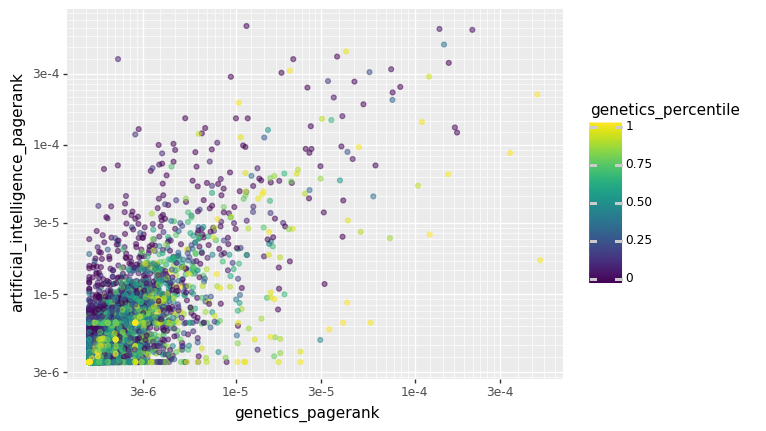

<ggplot: (8759344638880)>

In [21]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='genetics_percentile'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

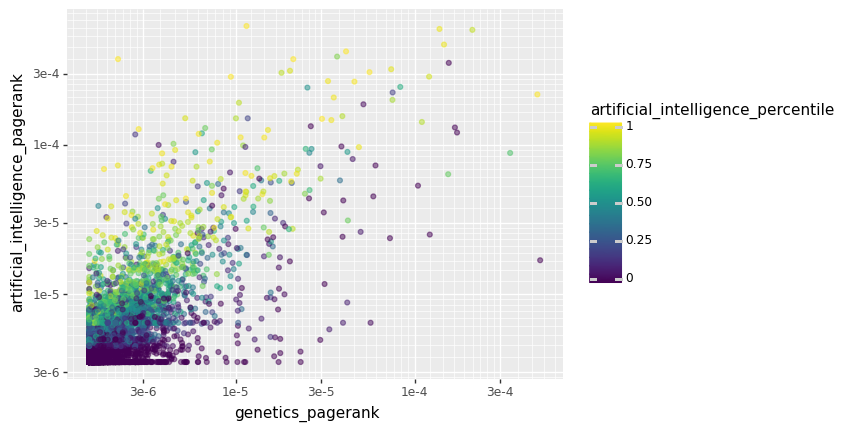

<ggplot: (8759344638781)>

In [22]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='artificial_intelligence_percentile',))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot

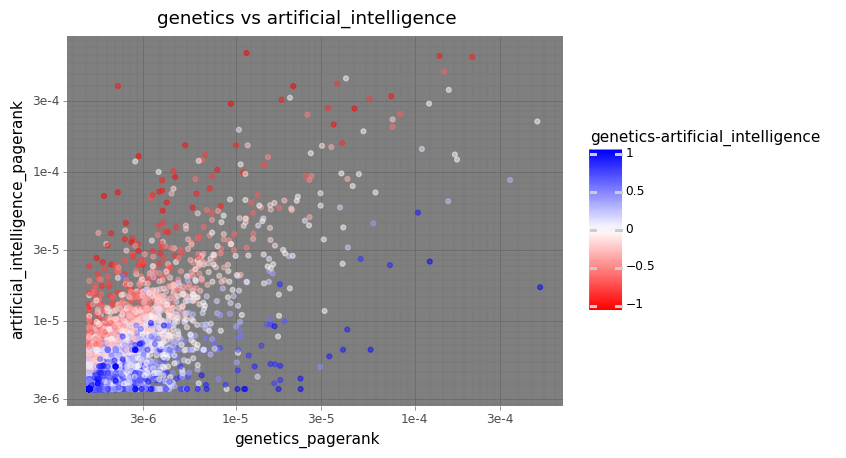

<ggplot: (8759298574054)>

In [23]:
plot = ggplot(merged_df, aes(x='genetics_pagerank', y='artificial_intelligence_pagerank', color='genetics-artificial_intelligence'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('genetics vs artificial_intelligence')
plot

In [24]:
# Get papers that did surprisingly well in genetics but surprisingly poorly in artificial_intelligence
merged_df.sort_values(by='genetics-artificial_intelligence', ascending=False).head(5)

doi  genetics_pagerank  genetics_percentile  \
7708     10.1182/blood.2021013054           0.000002                  1.0   
5144    10.1007/s00253-017-8385-3           0.000002                  1.0   
5133  10.1016/j.bbcan.2021.188572           0.000002                  1.0   
1626           10.1039/c5mb00657k           0.000002                  1.0   
5130   10.1186/s12920-021-00918-x           0.000002                  1.0   

      artificial_intelligence_pagerank  artificial_intelligence_percentile  \
7708                          0.000004                                 0.0   
5144                          0.000004                                 0.0   
5133                          0.000004                                 0.0   
1626                          0.000004                                 0.0   
5130                          0.000004                                 0.0   

      genetics-artificial_intelligence      pmid       pmcid  \
7708                               1.0  34657151  PMC8796655   
5144                               1.0  28647779        None   
5133                               1.0  34082064  PMC8922906   
1626                               1.0  26699092        None   
5130                               1.0  33653335  PMC7927383   

                              journal journal_nlm_id  \
7708                            Blood        7603509   
5144        Appl Microbiol Biotechnol        8406612   
5133  Biochim Biophys Acta Rev Cancer        9806362   
1626                      Mol Biosyst      101251620   
5130                 BMC Med Genomics      101319628   

                                                  title publication_date  \
7708  Signatures of GVHD and relapse after posttrans...       2022-01-27   
5144  Transcriptome profiling and digital gene expre...       2017-06-24   
5133  The case for AI-driven cancer clinical trials ...       2021-05-31   
1626  The relationships among host transcriptional r...          2016-02   
5130  Integrated analysis of lncRNA-miRNA-mRNA ceRNA...       2021-03-02   

                                                authors  
7708  [{'fore_name': 'Shannon R', 'last_name': 'McCu...  
5144  [{'fore_name': 'Yi-Gang', 'last_name': 'Xu', '...  
5133  [{'fore_name': 'Likhitha', 'last_name': 'Kolla...  
1626  [{'fore_name': 'Lu', 'last_name': 'Han', 'affi...  
5130  [{'fore_name': 'Lu', 'last_name': 'Gao', 'affi...

In [25]:
merged_df.sort_values(by='genetics-artificial_intelligence', ascending=True).head(5)

doi  genetics_pagerank  \
448                    10.1038/nature02236           0.000009   
168  10.1093/bioinformatics/17.suppl_1.s74           0.000021   
387          10.1093/bioinformatics/btu277           0.000011   
466          10.1093/bioinformatics/bti683           0.000002   
671                     10.1093/nar/gkt519           0.000003   

     genetics_percentile  artificial_intelligence_pagerank  \
448                  0.0                          0.000286   
168                  0.0                          0.000376   
387                  0.0                          0.000626   
466                  0.0                          0.000069   
671                  0.0                          0.000128   

     artificial_intelligence_percentile  genetics-artificial_intelligence  \
448                                1.00                             -1.00   
168                                1.00                             -1.00   
387                                1.00                             -1.00   
466                                0.99                             -0.99   
671                                0.99                             -0.99   

         pmid       pmcid            journal journal_nlm_id  \
448  14724639        None             Nature        0410462   
168  11472995        None     Bioinformatics        9808944   
387  24931975  PMC4058935     Bioinformatics        9808944   
466  16174682        None     Bioinformatics        9808944   
671  23771147  PMC3692045  Nucleic Acids Res        0411011   

                                                 title publication_date  \
448  Functional genomic hypothesis generation and e...       2004-01-15   
168  GENIES: a natural-language processing system f...             2001   
387  Deep learning of the tissue-regulated splicing...       2014-06-15   
466  ChemDB: a public database of small molecules a...       2005-09-20   
671  kmer-SVM: a web server for identifying predict...       2013-06-14   

                                               authors  
448  [{'fore_name': 'Ross D', 'last_name': 'King', ...  
168  [{'fore_name': 'C', 'last_name': 'Friedman', '...  
387  [{'fore_name': 'Michael K K', 'last_name': 'Le...  
466  [{'fore_name': 'Jonathan', 'last_name': 'Chen'...  
671  [{'fore_name': 'Christopher', 'last_name': 'Fl...

### Comp bio vs microbio

In [26]:
merged_df = load_pair_headings('computational_biology', 'microbiology')

In [27]:
fig = px.scatter(merged_df, x='computational_biology_pagerank', y='microbiology_pagerank', log_x=True, log_y=True, 
                 opacity=.5, color='computational_biology-microbiology', color_continuous_scale='RdBu', hover_data=['doi'],
                 title='Relative importance of papers in comp bio and genetics')
fig.show()

In [28]:
merged_df.sort_values(by='computational_biology-microbiology', ascending=True).head(5)

doi  computational_biology_pagerank  \
152  10.1128/aem.71.9.5544-5550.2005                        0.000009   
235        10.1016/j.mib.2010.02.001                        0.000003   
939        10.1016/j.mib.2010.08.001                        0.000002   
6          10.1007/s00253-001-0883-6                        0.000014   
674                10.1021/ac501371r                        0.000002   

     computational_biology_percentile  microbiology_pagerank  \
152                              0.00               0.000169   
235                              0.00               0.000029   
939                              0.03               0.000009   
6                                0.08               0.000071   
674                              0.02               0.000012   

     microbiology_percentile  computational_biology-microbiology      pmid  \
152                     0.97                               -0.97  16151147   
235                     0.96                               -0.96  20226723   
939                     0.92                               -0.89  20832353   
6                       0.90                               -0.82  11876415   
674                     0.84                               -0.82  24847944   

          pmcid                    journal journal_nlm_id  \
152  PMC1214672     Appl Environ Microbiol        7605801   
235  PMC2885540        Curr Opin Microbiol        9815056   
939        None        Curr Opin Microbiol        9815056   
6          None  Appl Microbiol Biotechnol        8406612   
674        None                  Anal Chem        0370536   

                                                 title publication_date  \
152  Fungal community analysis by large-scale seque...          2005-09   
235  Toward design-based engineering of industrial ...       2010-03-11   
939             The voyage of the microbial eukaryote.       2010-09-09   
6    A novel methodology employing Corynebacterium ...          2002-02   
674  Detection of Yersinia pestis in environmental ...       2014-05-29   

                                               authors  
152  [{'fore_name': 'Heath E', 'last_name': 'O'Brie...  
235  [{'fore_name': 'Keith E J', 'last_name': 'Tyo'...  
939  [{'fore_name': 'Alexandra Z', 'last_name': 'Wo...  
6    [{'fore_name': 'J', 'last_name': 'Ohnishi', 'a...  
674  [{'fore_name': 'Jérôme', 'last_name': 'Chenau'...

In [29]:
merged_df.sort_values(by='computational_biology-microbiology', ascending=False).head(5)

doi  computational_biology_pagerank  \
1397  10.1016/j.scitotenv.2021.152878                        0.000001   
1071             10.1128/aem.02434-20                        0.000001   
1145       10.1007/s10295-019-02145-x                        0.000001   
1144        10.1007/s10295-018-2063-z                        0.000001   
1138        10.1007/s10126-013-9522-3                        0.000001   

      computational_biology_percentile  microbiology_pagerank  \
1397                               1.0               0.000003   
1071                               1.0               0.000003   
1145                               1.0               0.000003   
1144                               1.0               0.000003   
1138                               1.0               0.000003   

      microbiology_percentile  computational_biology-microbiology      pmid  \
1397                      0.0                                 1.0  34998744   
1071                      0.0                                 1.0  33188002   
1145                      0.0                                 1.0  30715626   
1144                      0.0                                 1.0  30073539   
1138                      0.0                                 1.0  23949008   

           pmcid                     journal journal_nlm_id  \
1397        None           Sci Total Environ        0330500   
1071  PMC7848916      Appl Environ Microbiol        7605801   
1145        None  J Ind Microbiol Biotechnol        9705544   
1144        None  J Ind Microbiol Biotechnol        9705544   
1138        None         Mar Biotechnol (NY)      100892712   

                                                  title publication_date  \
1397  Integrated microbiology and metabolomics analy...       2022-01-05   
1071                           Industrially Applicable        2021-01-15   
1145  Comparison of gal-lac operons in wild-type gal...       2019-02-04   
1144  Overexpression of cytochrome p450 125 in Mycob...       2018-08-02   
1138  Characterisation of an L-haloacid dehalogenase...       2013-08-16   

                                                authors  
1397  [{'fore_name': 'Hongyan', 'last_name': 'Cheng'...  
1071  [{'fore_name': 'Zachari', 'last_name': 'Turgeo...  
1145  [{'fore_name': 'Zhi-Qiang', 'last_name': 'Xion...  
1144  [{'fore_name': 'Liqiu', 'last_name': 'Su', 'af...  
1138  [{'fore_name': 'Halina R', 'last_name': 'Novak...

### High CB - microbio
- The Universal Protein Resource (UniProt) 2009 
- Metagenomics for studying unculturable microorganisms: cutting the Gordian knot
- Phage Taxonomy: We Agree To Disagree
- Biotechnological prospects from metagenomics
- Pan-genome analysis of the emerging foodborne pathogen Cronobacterspp. suggests a species-level bidirectional divergence driven by niche adaptation

### High Microbio - CB
- Toward design-based engineering of industrial microbes
- Systems biology of yeast: enabling technology for development of cell factories for production of advanced biofuels
- Fungal Community Analysis by Large-Scale Sequencing of Environmental Samples
- Impact of systems biology on metabolic engineering of Saccharomyces cerevisiae 
- Industrial systems biology

### Top right (High pagerank in both)
- Community structure and metabolism through reconstruction of microbial genomes from the environment

### Comp bio vs medical informatics

In [30]:
merged_df = load_pair_headings('computational_biology', 'medical_informatics')
merged_df

doi  computational_biology_pagerank  \
0      10.1016/j.atherosclerosis.2008.10.014                        0.000003   
1               10.1371/journal.pbio.1002303                        0.000003   
2                10.1016/j.mcpro.2021.100077                        0.000002   
3                 10.1038/s41598-020-61204-x                        0.000002   
4                   10.1074/mcp.ra120.002251                        0.000001   
...                                      ...                             ...   
28934                    10.1093/bib/bbab238                        0.000001   
28935                   10.1038/clpt.2013.28                        0.000002   
28936                    10.1093/nar/gkq1008                        0.000021   
28937              10.1007/s11033-018-4391-5                        0.000002   
28938                      10.1038/srep03538                        0.000002   

       computational_biology_percentile  medical_informatics_pagerank  \
0                                  0.28                      0.000003   
1                                  0.37                      0.000001   
2                                  0.15                      0.000001   
3                                  0.83                      0.000001   
4                                  1.00                      0.000001   
...                                 ...                           ...   
28934                              1.00                      0.000001   
28935                              0.12                      0.000002   
28936                              0.28                      0.000018   
28937                              0.05                      0.000001   
28938                              0.06                      0.000001   

       medical_informatics_percentile  \
0                                0.74   
1                                0.11   
2                                0.00   
3                                0.00   
4                                0.00   
...                               ...   
28934                            0.00   
28935                            0.19   
28936                            0.51   
28937                            0.10   
28938                            0.02   

       computational_biology-medical_informatics      pmid       pmcid  \
0                                          -0.46  19046747  PMC2706316   
1                                           0.26  26600012  PMC4658184   
2                                           0.15  33813065  PMC8131922   
3                                           0.83  32144380  PMC7060309   
4                                           1.00  33008835  PMC7710135   
...                                          ...       ...         ...   
28934                                       1.00  34251419  PMC8574961   
28935                                      -0.07  23511712        None   
28936                                      -0.23  21051359  PMC3013640   
28937                                      -0.05  30238411        None   
28938                                       0.04  24346768  PMC3866686   

                   journal journal_nlm_id  \
0          Atherosclerosis        0242543   
1                PLoS Biol      101183755   
2      Mol Cell Proteomics      101125647   
3                  Sci Rep      101563288   
4      Mol Cell Proteomics      101125647   
...                    ...            ...   
28934      Brief Bioinform      100912837   
28935  Clin Pharmacol Ther        0372741   
28936    Nucleic Acids Res        0411011   
28937         Mol Biol Rep        0403234   
28938              Sci Rep      101563288   

                                                   title publication_date  \
0          Improvements to cardiovascular gene ontology.       2008-11-01   
1         Computing Workflows for Biologists: A Roadmap.       2015-11-24   
2      IonQuant Enables Accurate and Sensitive La

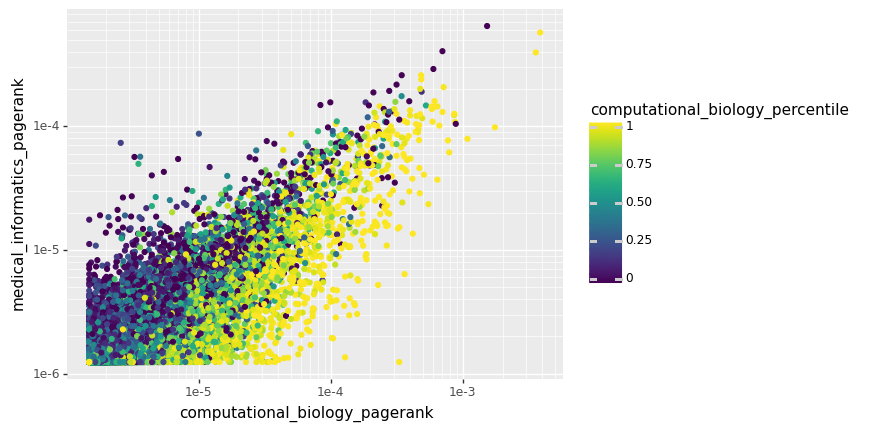

<ggplot: (8759331358817)>

In [31]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='computational_biology_percentile'))
plot += geom_point()
plot += scale_y_log10()
plot += scale_x_log10()
plot

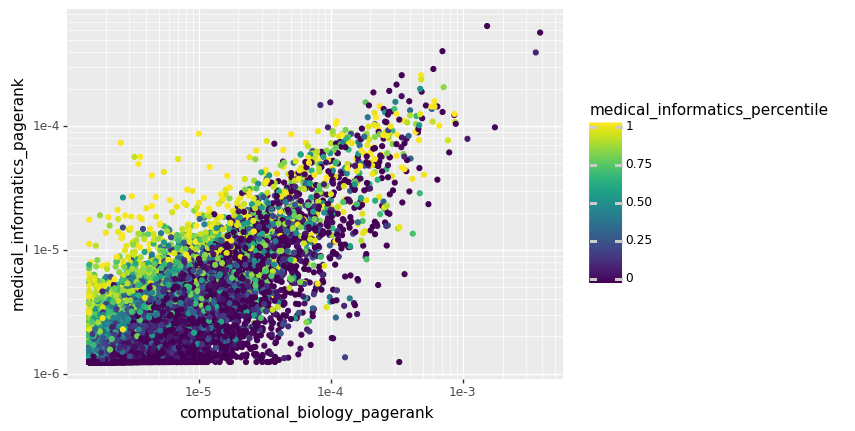

<ggplot: (8759344194972)>

In [32]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='medical_informatics_percentile',))
plot += geom_point()
plot += scale_y_log10()
plot += scale_x_log10()
plot

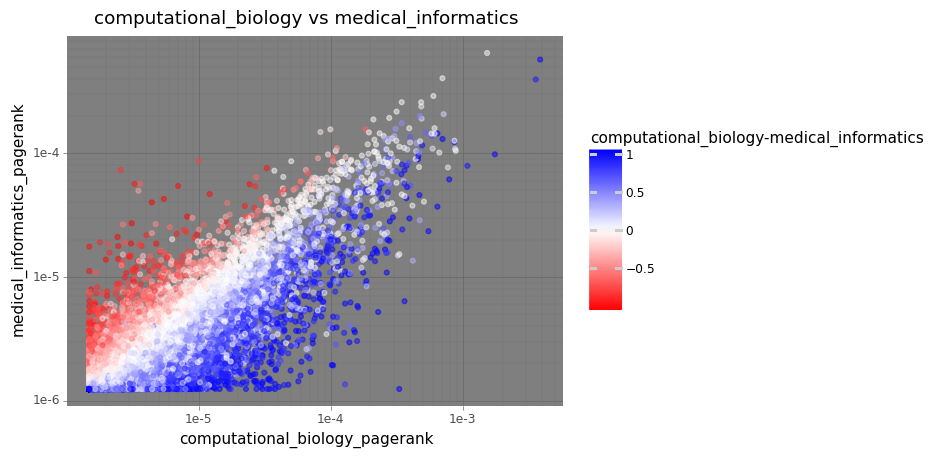

<ggplot: (8759243757070)>

In [33]:
plot = ggplot(merged_df, aes(x='computational_biology_pagerank', y='medical_informatics_pagerank', color='computational_biology-medical_informatics'))
plot += geom_point(alpha=.5)
plot += scale_y_log10()
plot += scale_x_log10()
plot += scale_color_gradient2(low='red', mid='white', high='blue')
plot += theme_dark()
plot += ggtitle('computational_biology vs medical_informatics')
plot

In [34]:
# Get papers that did surprisingly well in computational_biology but surprisingly poorly in medical_informatics
merged_df.sort_values(by='computational_biology-medical_informatics', ascending=False).head(5)

doi  computational_biology_pagerank  \
5258     10.1007/978-1-4939-1115-8_20                        0.000001   
3239   10.1093/bioinformatics/btaa994                        0.000001   
23257  10.1016/j.ijbiomac.2021.11.124                        0.000001   
3255       10.1186/s13073-021-00905-y                        0.000001   
21853        10.1093/database/baaa051                        0.000001   

       computational_biology_percentile  medical_informatics_pagerank  \
5258                                1.0                      0.000001   
3239                                1.0                      0.000001   
23257                               1.0                      0.000001   
3255                                1.0                      0.000001   
21853                               1.0                      0.000001   

       medical_informatics_percentile  \
5258                              0.0   
3239                              0.0   
23257                             0.0   
3255                              0.0   
21853                             0.0   

       computational_biology-medical_informatics      pmid       pmcid  \
5258                                         1.0  25048135        None   
3239                                         1.0  33289511  PMC8388034   
23257                                        1.0  34826456  PMC8610562   
3255                                         1.0  34034815  PMC8147418   
21853                                        1.0  32621601  PMC7334889   

                   journal journal_nlm_id  \
5258      Methods Mol Biol        9214969   
3239        Bioinformatics        9808944   
23257  Int J Biol Macromol        7909578   
3255            Genome Med      101475844   
21853    Database (Oxford)      101517697   

                                                   title publication_date  \
5258   Computational antigenic epitope prediction by ...             2014   
3239   AVIA 3.0: interactive portal for genomic varia...       2021-08-25   
23257  Identifying potential novel insights for COVID...       2021-11-24   
3255   Hard wiring of normal tissue-specific chromoso...       2021-05-25   
21853  SAGER: a database of Symbiodiniaceae and Algal...       2020-01-01   

                                                 authors  
5258   [{'fore_name': 'Sébastien', 'last_name': 'Fior...  
3239   [{'fore_name': 'Hue V', 'last_name': 'Reardon'...  
23257  [{'fore_name': 'Salem A', 'last_name': 'El-Aar...  
3255   [{'fore_name': 'Sushant', 'last_name': 'Patkar...  
21853  [{'fore_name': 'Liying', 'last_name': 'Yu', 'a...

In [35]:
merged_df.sort_values(by='computational_biology-medical_informatics', ascending=True).head(5)

doi  computational_biology_pagerank  \
1232              10.1038/ng0106-3                        0.000004   
7741           10.1093/nar/gkm1012                        0.000008   
25033          10.1197/jamia.m2233                        0.000003   
19674  10.1186/1471-2105-10-s9-s14                        0.000003   
11283     10.1109/titb.2008.917893                        0.000002   

       computational_biology_percentile  medical_informatics_pagerank  \
1232                               0.01                      0.000040   
7741                               0.00                      0.000031   
25033                              0.01                      0.000027   
19674                              0.00                      0.000019   
11283                              0.00                      0.000021   

       medical_informatics_percentile  \
1232                             1.00   
7741                             0.99   
25033                            1.00   
19674                            0.98   
11283                            0.98   

       computational_biology-medical_informatics      pmid       pmcid  \
1232                                       -0.99  16468121        None   
7741                                       -0.99  18029362  PMC2238982   
25033                                      -0.99  17329729  PMC2244877   
19674                                      -0.98  19761568  PMC2745685   
11283                                      -0.98  18348946  PMC2763494   

                             journal journal_nlm_id  \
1232                       Nat Genet        9216904   
7741               Nucleic Acids Res        0411011   
25033          J Am Med Inform Assoc        9430800   
19674             BMC Bioinformatics      100965194   
11283  IEEE Trans Inf Technol Biomed        9712259   

                                                   title publication_date  \
1232   A road map for efficient and reliable human ge...          2006-01   
7741   miRNAMap 2.0: genomic maps of microRNAs in met...       2007-11-19   
25033  Essie: a concept-based search engine for struc...       2007-02-28   
19674  Comparison of concept recognizers for building...       2009-09-17   
11283  A national human neuroimaging collaboratory en...          2008-03   

                                                 authors  
1232   [{'fore_name': 'John P A', 'last_name': 'Ioann...  
7741   [{'fore_name': 'Sheng-Da', 'last_name': 'Hsu',...  
25033  [{'fore_name': 'Nicholas C', 'last_name': 'Ide...  
19674  [{'fore_name': 'Nigam H', 'last_name': 'Shah',...  
11283  [{'fore_name': 'David B', 'last_name': 'Keator...

In [36]:
merged_df['percentile_sum'] = merged_df['computational_biology_percentile'] + merged_df['medical_informatics_percentile']
merged_df.sort_values(by='percentile_sum', ascending=False).head(5)

doi  computational_biology_pagerank  \
2642       10.1093/nar/gkp1078                        0.000076   
11761    10.1186/1471-2105-2-7                        0.000314   
11746   10.1186/1471-2105-10-2                        0.000103   
21520        10.1101/gr.903503                        0.000201   
12699  10.1126/science.1147699                        0.000109   

       computational_biology_percentile  medical_informatics_pagerank  \
2642                                1.0                      0.000063   
11761                               1.0                      0.000126   
11746                               1.0                      0.000046   
21520                               1.0                      0.000059   
12699                               1.0                      0.000104   

       medical_informatics_percentile  \
2642                              1.0   
11761                             1.0   
11746                             1.0   
21520                             1.0   
12699                             1.0   

       computational_biology-medical_informatics      pmid       pmcid  \
2642                                         0.0  19965774  PMC2808927   
11761                                        0.0  11667947    PMC58584   
11746                                        0.0  19123956  PMC2629762   
21520                                        0.0  12840046   PMC403744   
12699                                        0.0  17673640        None   

                  journal journal_nlm_id  \
2642    Nucleic Acids Res        0411011   
11761  BMC Bioinformatics      100965194   
11746  BMC Bioinformatics      100965194   
21520          Genome Res        9518021   
12699             Science        0404511   

                                                   title publication_date  \
2642          Archiving next generation sequencing data.       2009-12-03   
11761                 The distributed annotation system.       2001-10-10   
11746  GenomeGraphs: integrated genomic data visualiz...       2009-01-06   
21520  Subsystem identification through dimensionalit...          2003-07   
12699       Ethics. Identifiability in genomic research.       2007-08-03   

                                                 authors  percentile_sum  
2642   [{'fore_name': 'Martin', 'last_name': 'Shumway...             2.0  
11761  [{'fore_name': 'R D', 'last_name': 'Dowell', '...             2.0  
11746  [{'fore_name': 'Steffen', 'last_name': 'Durinc...             2.0  
21520  [{'fore_name': 'Philip M', 'last_name': 'Kim',...             2.0  
12699  [{'fore_name': 'William W', 'last_name': 'Lowr...             2.0

### High CB
- The Biomedical Data Translator Program: Conception, Culture, and Community
- Mean mass-specific metabolic rates are strikingly similar across life's major domains: Evidence for life's metabolic optimum
- Cross validation issues in multiobjective clustering
- Simultaneous Segmentation of Leukocyte and Erythrocyte in Microscopic Images Using a Marker-Controlled Watershed Algorithm
- A tiered approach to comparative genomics 

### High Medical informatics
- Human urinary biomarkers of dioxin exposure: Analysis by metabolomics and biologically driven data dimensionality reduction
- High-Resolution Metabolomics Assessment of Military Personnel Evaluating Analytical Strategies for Chemical Detection
- Development of High-Performance Chemical Isotope Labeling LC–MS for Profiling the Carbonyl Submetabolome
- Differential Carbonylation of Proteins as a Function of in vivo Oxidative Stress
- Fast gapped-read alignment with Bowtie 2

<AxesSubplot:>

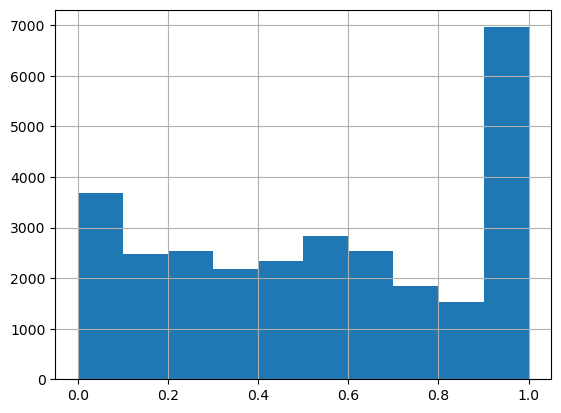

In [37]:
merged_df['computational_biology_percentile'].hist()

<AxesSubplot:>

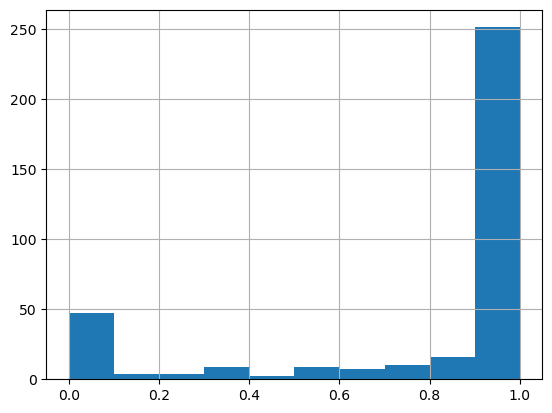

In [38]:
merged_df[merged_df['computational_biology_pagerank'] > 1e-4]['computational_biology_percentile'].hist()

<AxesSubplot:>

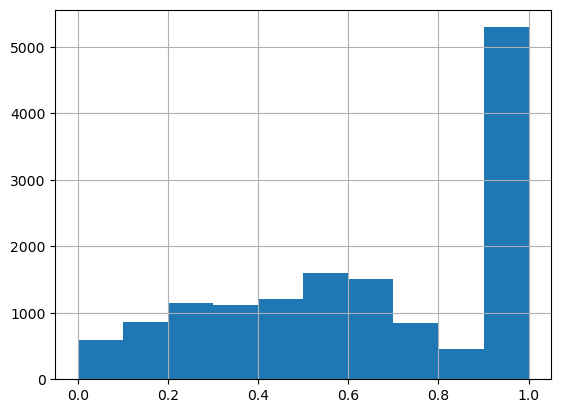

In [39]:
merged_df[merged_df['computational_biology_pagerank'] < 2e-6]['computational_biology_percentile'].hist()

In [40]:
merged_df['journal'].value_counts() > 100

Nucleic Acids Res         True
BMC Bioinformatics        True
Bioinformatics            True
Methods Mol Biol          True
PLoS One                  True
                         ...  
Eur J Neurol             False
Br J Radiol              False
Antioxid Redox Signal    False
Biol Lett                False
Redox Rep                False
Name: journal, Length: 1689, dtype: bool

In [41]:
journal_groups = merged_df.groupby('journal')
medians = journal_groups.median()
sizes = journal_groups.size()
medians[sizes > 100]

computational_biology_pagerank  \
journal                                                                
Adv Exp Med Biol                                            0.000002   
Anal Chem                                                   0.000004   
BMC Bioinformatics                                          0.000002   
BMC Genomics                                                0.000002   
BMC Syst Biol                                               0.000002   
Bioinformatics                                              0.000003   
Biomed Res Int                                              0.000001   
Brief Bioinform                                             0.000002   
Comput Biol Chem                                            0.000002   
Comput Biol Med                                             0.000002   
Comput Math Methods Med                                     0.000001   
Database (Oxford)                                           0.000002   
Gene                                                        0.000002   
Genome Biol                                                 0.000005   
Genome Res                                                  0.000009   
Hum Mutat                                                   0.000002   
IEEE/ACM Trans Comput Biol Bioinform                        0.000002   
Int J Mol Sci                                               0.000002   
J Bioinform Comput Biol                                     0.000002   
J Biomed Inform                                             0.000002   
J Chem Inf Model                                            0.000002   
J Comput Biol                                               0.000002   
J Mol Biol                                                  0.000007   
J Proteome Res                                              0.000003   
J Proteomics                                                0.000002   
J Theor Biol                                                0.000002   
Methods Mol Biol                                            0.000002   
Mol Biosyst                                                 0.000002   
Mol Cell Proteomics                                         0.000004   
Mol Med Rep                                                 0.000001   
Nat Commun                                                  0.000002   
Nat Methods                                                 0.000006   
Nucleic Acids Res                                           0.000005   
Oncotarget                                                  0.000002   
PLoS Comput Biol                                            0.000002   
PLoS One                                                    0.000002   
Proc Natl Acad Sci U S A                                    0.000005   
Protein Sci                                                 0.000002   
Proteins                                                    0.000003   
Proteomics                                                  0.000004   
Sci Rep                                                     0.000002   
Science                                                     0.000023   

                                      computational_biology_percentile  \
journal                                                                  
Adv Exp Med Biol                                                 0.650   
Anal Chem                                                        0.220   
BMC Bioinformatics                                               0.460   
BMC Genomics                                                     0.485   
BMC Syst Biol                                                    0.455   
Bioinformatics                                                   0.460   
Biomed Res Int                                                   0.970   
Brief Bioinform                                                  0.530   
Comput Biol Chem                                                 0.600   
Comput Biol Med                                        

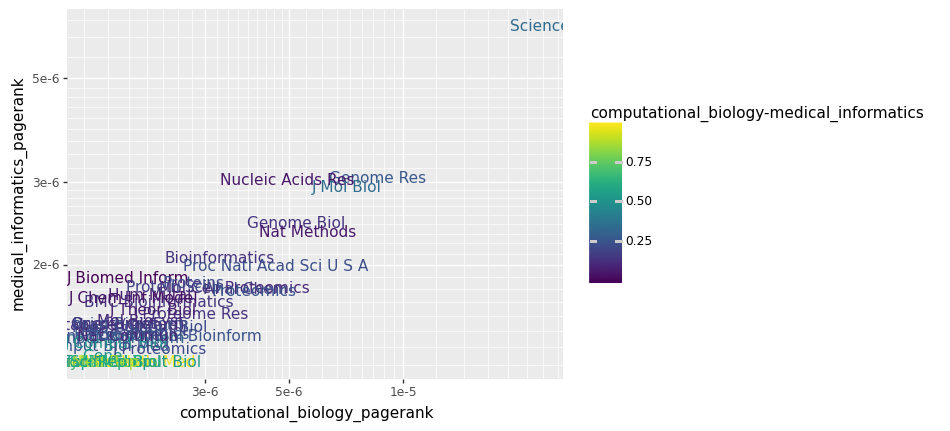

<ggplot: (8759265242923)>

In [42]:
medians['journal_title'] = medians.index
plot = ggplot(medians[sizes > 100], aes(x='computational_biology_pagerank', 
                                        y='medical_informatics_pagerank', 
                                        color='computational_biology-medical_informatics'))
plot += geom_text(aes(label='journal_title'))
plot += scale_y_log10()
plot += scale_x_log10()
plot

In [43]:
fig = px.scatter(medians[sizes > 100],x='computational_biology_pagerank', 
                                      y='medical_informatics_pagerank', log_x=True, log_y=True, 
                                      color='computational_biology-medical_informatics', title='Journals',
                                      hover_data = ['journal_title'])
fig

In [50]:
merged_df = load_pair_headings('computational_biology', 'genetics')

In [51]:
journal_groups = merged_df.groupby('journal')
medians = journal_groups.median()
sizes = journal_groups.size()

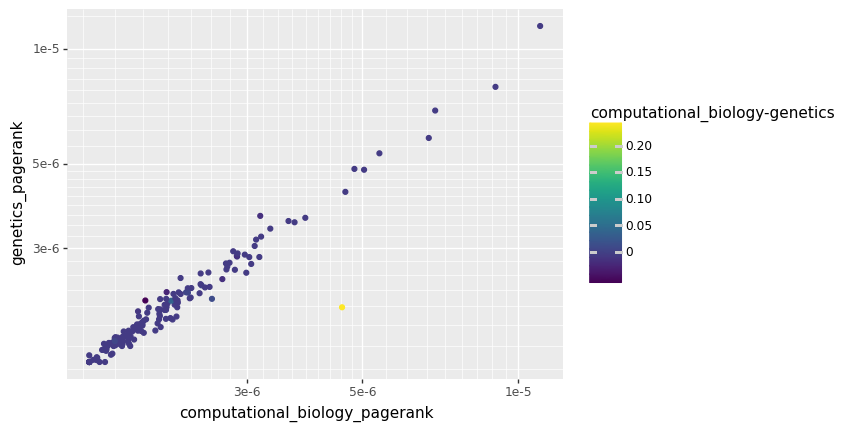

<ggplot: (8759305736766)>

In [52]:
medians['journal_title'] = medians.index
plot = ggplot(medians[sizes > 100], aes(x='computational_biology_pagerank', 
                                        y='genetics_pagerank', 
                                        color='computational_biology-genetics'))
plot += geom_point()
plot += scale_y_log10()
plot += scale_x_log10()
plot

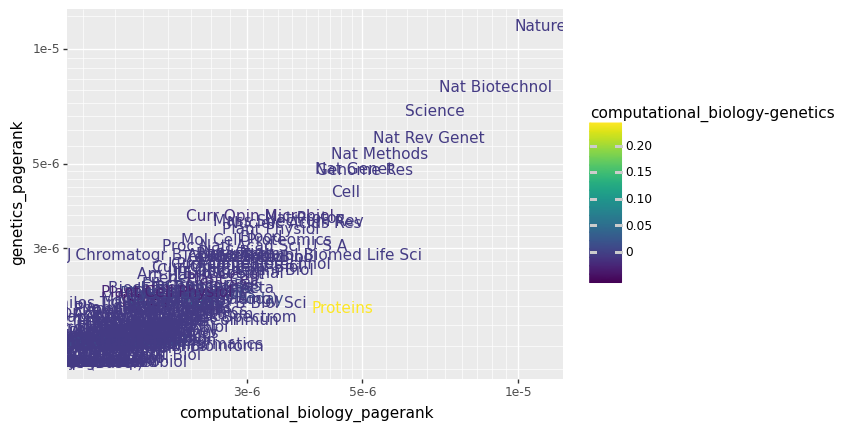

<ggplot: (8759235651891)>

In [53]:
medians['journal_title'] = medians.index
plot = ggplot(medians[sizes > 100], aes(x='computational_biology_pagerank', 
                                        y='genetics_pagerank', 
                                        color='computational_biology-genetics'))
plot += geom_text(aes(label='journal_title'))
plot += scale_y_log10()
plot += scale_x_log10()
plot

In [54]:
fig = px.scatter(medians[sizes > 100],x='computational_biology_pagerank', 
                                      y='genetics_pagerank', log_x=True, log_y=True, 
                                      color='computational_biology-genetics', title='Journals',
                                      hover_data = ['journal_title'])
fig

### Plot and save results

In [49]:
headings = ["artificial_intelligence", "computational_biology", 
            "ecology", "genetics", "medical_informatics", "microbiology"]

for heading1, heading2 in tqdm(itertools.combinations(headings, 2), total=15):

    merged_df = load_pair_headings(heading1, heading2)

    journal_groups = merged_df.groupby('journal')
    medians = journal_groups.median()
    sizes = journal_groups.size()

    medians['journal_title'] = medians.index
    plot = ggplot(medians[sizes > 100], aes(x=f'{heading1}_pagerank', 
                                            y=f'{heading2}_pagerank', 
                                            color=f'{heading1}-{heading2}'))
    plot += geom_text(aes(label='journal_title'))
    plot += scale_y_log10()
    plot += scale_x_log10()
    plot += ggtitle(f'{heading1} vs {heading2} journals')
    
    plot.save(f'../output/figures/{heading1}-{heading2}-journals.png')
    
    plot = ggplot(merged_df, aes(x=f'{heading1}_pagerank', y=f'{heading2}_pagerank', color=f'{heading1}-{heading2}'))
    plot += geom_point(alpha=.5)
    plot += scale_y_log10()
    plot += scale_x_log10()
    plot += scale_color_gradient2(low='red', mid='white', high='blue')
    plot += theme_dark()
    plot += ggtitle(f'{heading1} vs {heading2} papers')
    plot.save(f'../output/figures/{heading1}-{heading2}-papers.png')

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/artificial_intelligence-computational_biology-journals.png

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/artificial_intelligence-computational_biology-papers.png

  7%|███████████▏                                                                                                                                 

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 10/15 [04:21<02:13, 26.70s/it]/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/ecology-medical_informatics-journals.png

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning:

Saving 6.4 x 4.8 in image.

/home/heil/anaconda3/envs/indices/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning:

Filename: ../output/figures/ecology-medical_informatics-papers.png

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 11/15 [0